# Real-world Temporal Network Simulations
Here we will illustrate how the DelayBufferNetwork framework can be used to build temporal networks on real-world data. We use the Workplace15 data set here, from sociopatterns.org (http://www.sociopatterns.org/datasets/contacts-in-a-workplace/)

Keep in mind that this uses an older version of DelayBufferNetwork. Using the updated framework is recommended but it will not work in the same way.

First, load in the data (which was preprocessed from the original contact representation format (t: {agent_1, agent_2, ...}) to event format (i, j, t, event_id))



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
import os
sys.path.append(os.path.abspath('..'))
from Timeliness_criticality import DelayBufferNetwork

In [20]:

event_data = np.load("Workplace15/Workplace15.npy")
df = pd.DataFrame(event_data, columns=["i", "j", "t", "weight", "event_id"])

# Create a dictionary to map the old agent IDs to the new agent IDs
agent_id_map = {old_id: new_id for new_id, old_id in enumerate(sorted(df['i'].unique()))}
agent_id_mapj = {old_id: new_id for new_id, old_id in enumerate(sorted(df['j'].unique()))}
t_map = {old_id: new_id for new_id, old_id in enumerate(sorted(df['t'].unique()))}

# Map the old agent IDs to the new agent IDs in the DataFrame
df['i'] = df['i'].map(agent_id_map)
df['j'] = df['j'].map(agent_id_mapj)
df['t'] = df['t'].map(t_map)

Build the Network by initializing a DBN

In [8]:
dbn = DelayBufferNetwork(nettype = "wd", from_df=df, uniform_time_range=True, dont_build_df=True, del_df=True)
# save it in case you need it later
dbn.save_event_arrays("Workplace15/1")
dbn.save_event_dict("Workplace15/1")

First, do a practice run

In [9]:
def sim(b):
    dbn = DelayBufferNetwork(load=True, path="Workplace15/1")
    dbn.add_delay(expon_distr_bool=True, tau = 1, using_event_dict=True)
    dbn.add_event_buffer(buffer=b, uniform_buffer_bool=True, using_event_dict=True)
    dbn.process_delays_fast_arrays(interact_with_topology=False)
    event_delays = dbn.event_current_delay_array
    agent_delays = np.mean(dbn.agent_delays, axis=1)
    return event_delays, agent_delays

In [11]:
result = sim(b=1)

Let's see the results of this single run.

Text(0, 0.5, 'Mean delay per node')

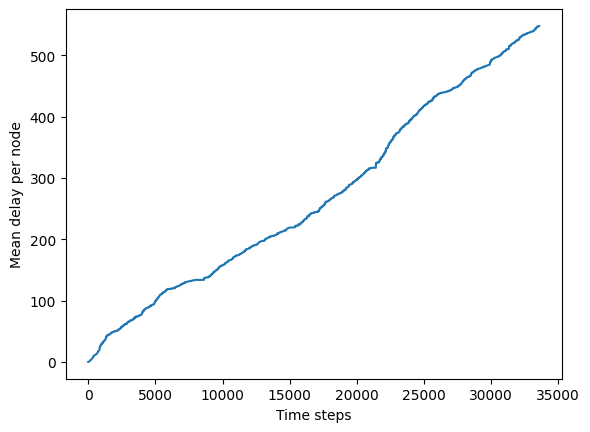

In [12]:
plt.plot(range(len(result[1])), result[1])
plt.xlabel("Time steps")
plt.ylabel("Mean delay per node")

To create a $v$ versus $B$ graph, we must do more simulations.

Let's set our simulation settings

In [13]:
buffers = np.arange(0, 5, 0.1)

Simulate! (it roughly takes the same time as the single simulation / number of threads * 50)

In [14]:
from joblib import Parallel, delayed
results = Parallel(n_jobs=4)(delayed(sim)(buffers[i]) for i in range(len(buffers)))

/Users/lschoonheid/Dropbox/Docs/UvA/Master Computational Science/period 3/Complex System Simulation/CLS-7/.css/lib/python3.11/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
/Users/lschoonheid/Dropbox/Docs/UvA/Master Computational Science/period 3/Complex System Simulation/CLS-7/.css/lib/python3.11/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
/Users/lschoonheid/Dropbox/Docs/UvA/Master Computational Science/period 3/Complex System Simulation/CLS-7/.css/lib/python3.11/site-packages/nilear

Reformat the results to give us $V$

In [15]:
delays_prop = []
for i in range(len(results)):
    delays_prop.append(results[i][1][1:] - results[i][1][:-1])

Now we can plot a simple $v$ versus $B$ graph

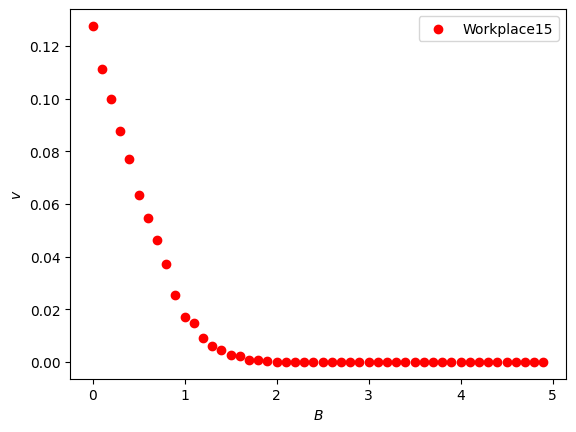

In [21]:
for i, b in enumerate(buffers):
    plt.scatter(b, np.mean(delays_prop[i]), c="r")
    
plt.legend(["Workplace15"])

plt.xlabel(r"$B$")
plt.ylabel(r"$v$")

plt.show()